In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/data.csv


In [2]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from scipy.stats import chi2

In [3]:
dataset = pd.read_csv('/kaggle/input/data.csv')
dataset.shape

(10382, 112)

In [4]:
numerical_col = dataset.describe().columns
cols = []
for col in dataset.columns:
    if col not in numerical_col:
        cols.append(col)
cols

['installation_id',
 'game_session',
 'title',
 'type',
 'world',
 'time_start',
 'time_end']

In [5]:
DUMMYS = ['title', 'type', 'world']
data = pd.get_dummies(dataset, columns=DUMMYS, drop_first=True)

In [6]:
data.groupby('Acc_group').agg({'installation_id': 'count'})

,installation_id
Acc_group,
0,8947
1,190
2,208
3,1037


In [7]:
LABELS = ['installation_id', 'game_session', 'time_start', 'time_end', 'Acc_group', 'Acc_group_avg', 'Correct', 'Incorrect', 'Acc']
FEATURES = data.drop(LABELS,axis = 1).keys()

In [8]:
X = data[FEATURES].values
y = data['Acc_group'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train, y_train, train_size=0.75)

In [9]:
def cv_train(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    scoring = model.cv_results_
    for mean_score, std, params in zip(scoring['mean_test_score'],scoring['std_test_score'],scoring['params']):
        print("{:0.3f} (+/-{:0.03f}) for {}".format(
                mean_score, std * 2, params))  
    print('\nBest parameters:', model.best_params_)
    print(classification_report(y_test, model.predict(X_test).astype(int)))

In [10]:
import random

NUM_SAMPLES = 10
NUM_TRAIN_SETS = 10

def subsample(X, y, sample_size):
    xy_tuples = list(zip(X, y))
    xy_sample = [random.choice(xy_tuples) for _ in range(sample_size)]
    X_sample, y_sample = zip(*xy_sample)
    return X_sample, y_sample

def error(clf, X, y):
    "Calculate error as 1-accuracy"
    return 1-clf.score(X,y)

def bootstrap_error(clf, X_train, y_train, X_test, y_test, sample_size, num_samples=NUM_SAMPLES):
    train_errors = []
    test_errors = []
    for _ in range(num_samples):
        X_sample, y_sample = subsample(X_train, y_train, sample_size)
        clf.fit(X_sample, y_sample)
        train_errors.append(error(clf,X_sample,y_sample))
        test_errors.append(error(clf,X_test,y_test))
    train_error = sum(train_errors)/len(train_errors)
    test_error = sum(test_errors)/len(test_errors)
    return train_error, test_error

Decision tree classifier

In [11]:
param_grid = [
    {'max_depth': list(range(1, 10)),
     'criterion': ['entropy', 'gini'],
     'splitter': ['best', 'random']}
]
tree = GridSearchCV(DecisionTreeClassifier(), param_grid)
cv_train(tree, X_train, y_train, X_test, y_test)

0.862 (+/-0.000) for {'criterion': 'entropy', 'max_depth': 1, 'splitter': 'best'}
0.862 (+/-0.000) for {'criterion': 'entropy', 'max_depth': 1, 'splitter': 'random'}
0.862 (+/-0.000) for {'criterion': 'entropy', 'max_depth': 2, 'splitter': 'best'}
0.867 (+/-0.007) for {'criterion': 'entropy', 'max_depth': 2, 'splitter': 'random'}
0.866 (+/-0.004) for {'criterion': 'entropy', 'max_depth': 3, 'splitter': 'best'}
0.869 (+/-0.007) for {'criterion': 'entropy', 'max_depth': 3, 'splitter': 'random'}
0.870 (+/-0.004) for {'criterion': 'entropy', 'max_depth': 4, 'splitter': 'best'}
0.869 (+/-0.007) for {'criterion': 'entropy', 'max_depth': 4, 'splitter': 'random'}
0.873 (+/-0.008) for {'criterion': 'entropy', 'max_depth': 5, 'splitter': 'best'}
0.873 (+/-0.012) for {'criterion': 'entropy', 'max_depth': 5, 'splitter': 'random'}
0.873 (+/-0.005) for {'criterion': 'entropy', 'max_depth': 6, 'splitter': 'best'}
0.873 (+/-0.010) for {'criterion': 'entropy', 'max_depth': 6, 'splitter': 'random'}
0.87

In [12]:
best_tree = DecisionTreeClassifier(max_depth=5)
best_tree.fit(X_train, y_train)
export_graphviz(best_tree, out_file = 'tree.dot', feature_names = FEATURES, class_names=['0', '1', '2', '3'], filled = True)
important_feature = []
for idx in range(len(best_tree.feature_importances_)):
    if best_tree.feature_importances_[idx] != 0:
        important_feature.append((FEATURES[idx], best_tree.feature_importances_[idx]))
sorted(important_feature, key=lambda x: x[1], reverse=True)

[('Acc_avg', 0.48641873692032794),
 ('title_Leaf Leader', 0.1440102851053125),
 ('Game', 0.11721294689914545),
 ('2000_sum', 0.04641608924817329),
 ('4100', 0.04517841673630899),
 ('title_Chow Time', 0.028848799232817406),
 ('4010_sum', 0.021263195069279737),
 ('2060_sum', 0.019789718660889778),
 ('Assessment', 0.016267620388903604),
 ('4110_sum', 0.01543017870540254),
 ('4021_sum', 0.013372294381900638),
 ('4090_sum', 0.011230413489696224),
 ('4022_sum', 0.008184600324725996),
 ('4045_sum', 0.006273875339170231),
 ('event_count', 0.005572947874537662),
 ('3110_sum', 0.005515494803666139),
 ('4025_sum', 0.005377607433574487),
 ('3010_sum', 0.0036367793861673595)]

Text(0.5, 1.0, 'count of each accuray group for each title')

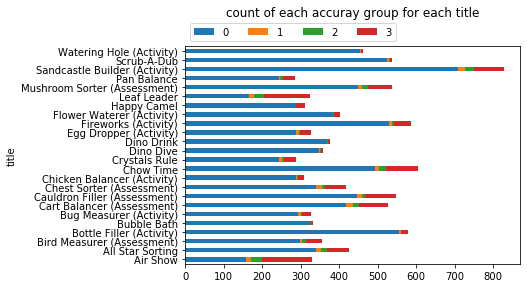

In [13]:
count_by_title = dataset.groupby(['title', 'Acc_group'])['game_session'].count().unstack('Acc_group')
# print(count_by_title)
ax = count_by_title.plot.barh(stacked=True)
ax.legend(ncol=4, bbox_to_anchor=(0, 1), loc='lower left')
plt.title('count of each accuray group for each title', pad = 30)

AdaBoost Classifier

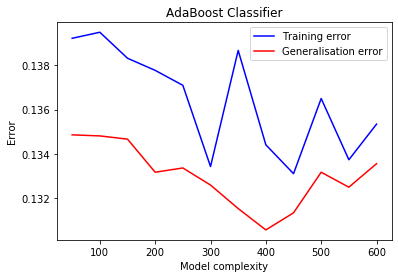

In [14]:
complexities = []
train_errors = []
test_errors = []
for n in list(range(50, 601, 50)):
    clf = AdaBoostClassifier(learning_rate=0.1, n_estimators=n)
    train_error, test_error = bootstrap_error(clf, X_train_2, y_train_2, X_valid, y_valid, len(y_train_2))
    complexities.append(n)
    train_errors.append(train_error)
    test_errors.append(test_error)
plt.plot(complexities, train_errors, c='b', label='Training error')
plt.plot(complexities, test_errors, c='r', label='Generalisation error')
plt.ylabel('Error')
plt.xlabel('Model complexity')
plt.title('AdaBoost Classifier')
plt.legend()
plt.show()

In [25]:
param_grid = [{'learning_rate': [0.001, 0.01, 0.1, 1]}]
ada = GridSearchCV(AdaBoostClassifier(n_estimators=300), param_grid)
cv_train(ada, X_train, y_train, X_test, y_test)

0.862 (+/-0.000) for {'learning_rate': 0.001}
0.862 (+/-0.000) for {'learning_rate': 0.01}
0.867 (+/-0.005) for {'learning_rate': 0.1}
0.787 (+/-0.017) for {'learning_rate': 1}

Best parameters: {'learning_rate': 0.1}
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      1786
           1       0.00      0.00      0.00        35
           2       1.00      0.03      0.05        37
           3       0.88      0.03      0.06       219

    accuracy                           0.86      2077
   macro avg       0.68      0.26      0.26      2077
weighted avg       0.85      0.86      0.80      2077



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
best_ada = AdaBoostClassifier(learning_rate=0.1, n_estimators=300)
best_ada.fit(X_train, y_train)
important_feature = []
for idx in range(len(best_ada.feature_importances_)):
    if best_ada.feature_importances_[idx] != 0:
        important_feature.append((FEATURES[idx], best_ada.feature_importances_[idx]))
sorted(important_feature, key=lambda x: x[1], reverse=True)

[('Acc_avg', 0.10666666666666667),
 ('Incorrect_total', 0.056666666666666664),
 ('4220_sum', 0.043333333333333335),
 ('Activity', 0.04),
 ('Assessment', 0.04),
 ('Acc_total', 0.04),
 ('2080', 0.03666666666666667),
 ('2010_sum', 0.03666666666666667),
 ('4025_sum', 0.03333333333333333),
 ('MAGMAPEAK', 0.03),
 ('3120', 0.03),
 ('2020_sum', 0.03),
 ('2040_sum', 0.02666666666666667),
 ('event_count', 0.023333333333333334),
 ('CRYSTALCAVES', 0.023333333333333334),
 ('3110', 0.023333333333333334),
 ('4010_sum', 0.023333333333333334),
 ('4035_sum', 0.023333333333333334),
 ('duration', 0.02),
 ('2060', 0.02),
 ('title_Dino Dive', 0.02),
 ('4021', 0.016666666666666666),
 ('4021_sum', 0.016666666666666666),
 ('3020_sum', 0.016666666666666666),
 ('hour', 0.013333333333333334),
 ('4025', 0.013333333333333334),
 ('4022', 0.013333333333333334),
 ('title_All Star Sorting', 0.013333333333333334),
 ('title_Bottle Filler (Activity)', 0.013333333333333334),
 ('TREETOPCITY', 0.01),
 ('4040', 0.01),
 ('4031

Random Forest Classifier

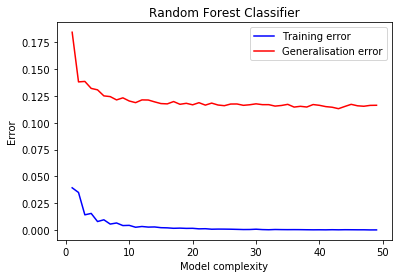

In [17]:
complexities = []
train_errors = []
test_errors = []
for n in list(range(1, 50)):
    clf = RandomForestClassifier(n_estimators=n)
    train_error, test_error = bootstrap_error(clf, X_train_2, y_train_2, X_valid, y_valid, len(y_train_2))
    complexities.append(n)
    train_errors.append(train_error)
    test_errors.append(test_error)
plt.plot(complexities, train_errors, c='b', label='Training error')
plt.plot(complexities, test_errors, c='r', label='Generalisation error')
plt.ylabel('Error')
plt.xlabel('Model complexity')
plt.title('Random Forest Classifier')
plt.legend()
plt.show()

In [18]:
param_grid = [
    {'criterion': ['entropy', 'gini'],
     'max_features': ['sqrt', 'log2'],
     'class_weight': ['balanced', 'balanced_subsample', None]}
]
svc = GridSearchCV(RandomForestClassifier(n_estimators=10), param_grid)
cv_train(svc, X_train, y_train, X_test, y_test)

0.870 (+/-0.009) for {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt'}
0.869 (+/-0.004) for {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2'}
0.866 (+/-0.004) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt'}
0.868 (+/-0.006) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2'}
0.870 (+/-0.008) for {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt'}
0.871 (+/-0.005) for {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2'}
0.870 (+/-0.004) for {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt'}
0.868 (+/-0.007) for {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2'}
0.876 (+/-0.008) for {'class_weight': None, 'criterion': 'entropy', 'max_features': 'sqrt'}
0.876 (+/-0.005) for {'class_weight': None, 'criterion': 'entropy', 'max_features': 'log2'}
0.87

In [19]:
best_forest = RandomForestClassifier(n_estimators=10)
best_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

K Neighbors Classifier

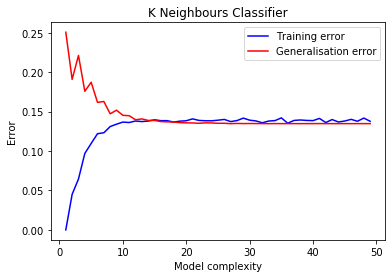

In [20]:
complexities = []
train_errors = []
test_errors = []
for n in list(range(1, 50)):
    clf = KNeighborsClassifier(n_neighbors=n)
    train_error, test_error = bootstrap_error(clf, X_train_2, y_train_2, X_valid, y_valid, len(y_train_2))
    complexities.append(n)
    train_errors.append(train_error)
    test_errors.append(test_error)
plt.plot(complexities, train_errors, c='b', label='Training error')
plt.plot(complexities, test_errors, c='r', label='Generalisation error')
plt.ylabel('Error')
plt.xlabel('Model complexity')
plt.title('K Neighbours Classifier')
plt.legend()
plt.show()

In [21]:
param_grid = [
    {'leaf_size': [10, 20, 30, 40, 50],
     'p': [1, 2]}
]
knn = GridSearchCV(KNeighborsClassifier(n_neighbors=10), param_grid)
cv_train(knn, X_train, y_train, X_test, y_test)

0.861 (+/-0.001) for {'leaf_size': 10, 'p': 1}
0.862 (+/-0.001) for {'leaf_size': 10, 'p': 2}
0.861 (+/-0.001) for {'leaf_size': 20, 'p': 1}
0.862 (+/-0.001) for {'leaf_size': 20, 'p': 2}
0.861 (+/-0.001) for {'leaf_size': 30, 'p': 1}
0.862 (+/-0.001) for {'leaf_size': 30, 'p': 2}
0.861 (+/-0.001) for {'leaf_size': 40, 'p': 1}
0.862 (+/-0.001) for {'leaf_size': 40, 'p': 2}
0.861 (+/-0.001) for {'leaf_size': 50, 'p': 1}
0.862 (+/-0.001) for {'leaf_size': 50, 'p': 2}

Best parameters: {'leaf_size': 10, 'p': 2}
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1786
           1       0.00      0.00      0.00        35
           2       0.00      0.00      0.00        37
           3       0.00      0.00      0.00       219

    accuracy                           0.86      2077
   macro avg       0.21      0.25      0.23      2077
weighted avg       0.74      0.86      0.80      2077



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
best_knn = KNeighborsClassifier(n_neighbors=10, leaf_size=10, p=1)
best_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=1,
                     weights='uniform')

Compare

In [23]:
def mcnemar(x, y):
    n1 = np.sum(x < y)w
    n2 = np.sum(x > y)
    stat = (np.abs(n1-n2)-1)**2 / (n1+n2)
    df = 1
    pval = chi2.sf(stat,1)
    return stat, pval

In [27]:
predict_tree = np.array([int(p==t) for p,t in zip(best_tree.predict(X_test), y_test)])
predict_ada = np.array([int(p==t) for p,t in zip(best_ada.predict(X_test), y_test)])
predict_forest = np.array([int(p==t) for p,t in zip(best_forest.predict(X_test), y_test)])
predict_knn = np.array([int(p==t) for p,t in zip(best_knn.predict(X_test), y_test)])

In [30]:
stats = np.zeros((4, 4))
pvals = np.zeros((4, 4))
predicts = [predict_tree, predict_ada, predict_forest, predict_knn]
for i in range(4):
    for j in range(i, 4):
        stat, pval = mcnemar(predicts[i], predicts[j])
        stats[i][j] = stat
        pvals[i][j] = pval
score, pvals

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in long_scalars
  after removing the cwd from sys.path.


(array([[0.00000000e+00, 6.34920635e+00, 4.70588235e-02, 1.00895522e+01],
        [1.17433823e-02, 0.00000000e+00, 5.29000000e+00, 2.50000000e+00],
        [8.28262541e-01, 2.14482200e-02, 0.00000000e+00, 8.08653846e+00],
        [1.49112334e-03, 1.13846298e-01, 4.45952577e-03, 0.00000000e+00]]),
 array([[0.        , 0.01174338, 0.82826254, 0.00149112],
        [0.        , 0.        , 0.02144822, 0.1138463 ],
        [0.        , 0.        , 0.        , 0.00445953],
        [0.        , 0.        , 0.        , 0.        ]]))